# Analysis Of Fractal Dimension Polices

This notebook contains code to generate all the plots and tables found in the manuscript, with the exception of the lower half of figure 3 which was produced in GIMP.

In [37]:
import torch
import matplotlib.pyplot as plt
from common import *
import time
import copy
import gym

import xarray as xr
import numpy as np

import os
import matplotlib

import pybullet_envs

def do_rollout_push(env, policy, magnitude, rate, num_steps=1000, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []


    dtype = torch.float32
    obs = env.reset()
    done = False

    for cur_step in range(num_steps):
        
        if np.random.uniform() < rate:
            force = np.random.randn(2)
            force = (force / np.linalg.norm(force))*magnitude
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.array([force[0],0,force[1],0,0,0])
            
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])


        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)


    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list


def do_rollout_noise(env, policy, obs_std=.001, act_std=.01, num_steps=1000, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs += torch.randn(obs_size)*obs_std
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])
        

        act = policy(obs)
        act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(np.clip(act.numpy(),-1,1))
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)


    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list

# Variation dimensions

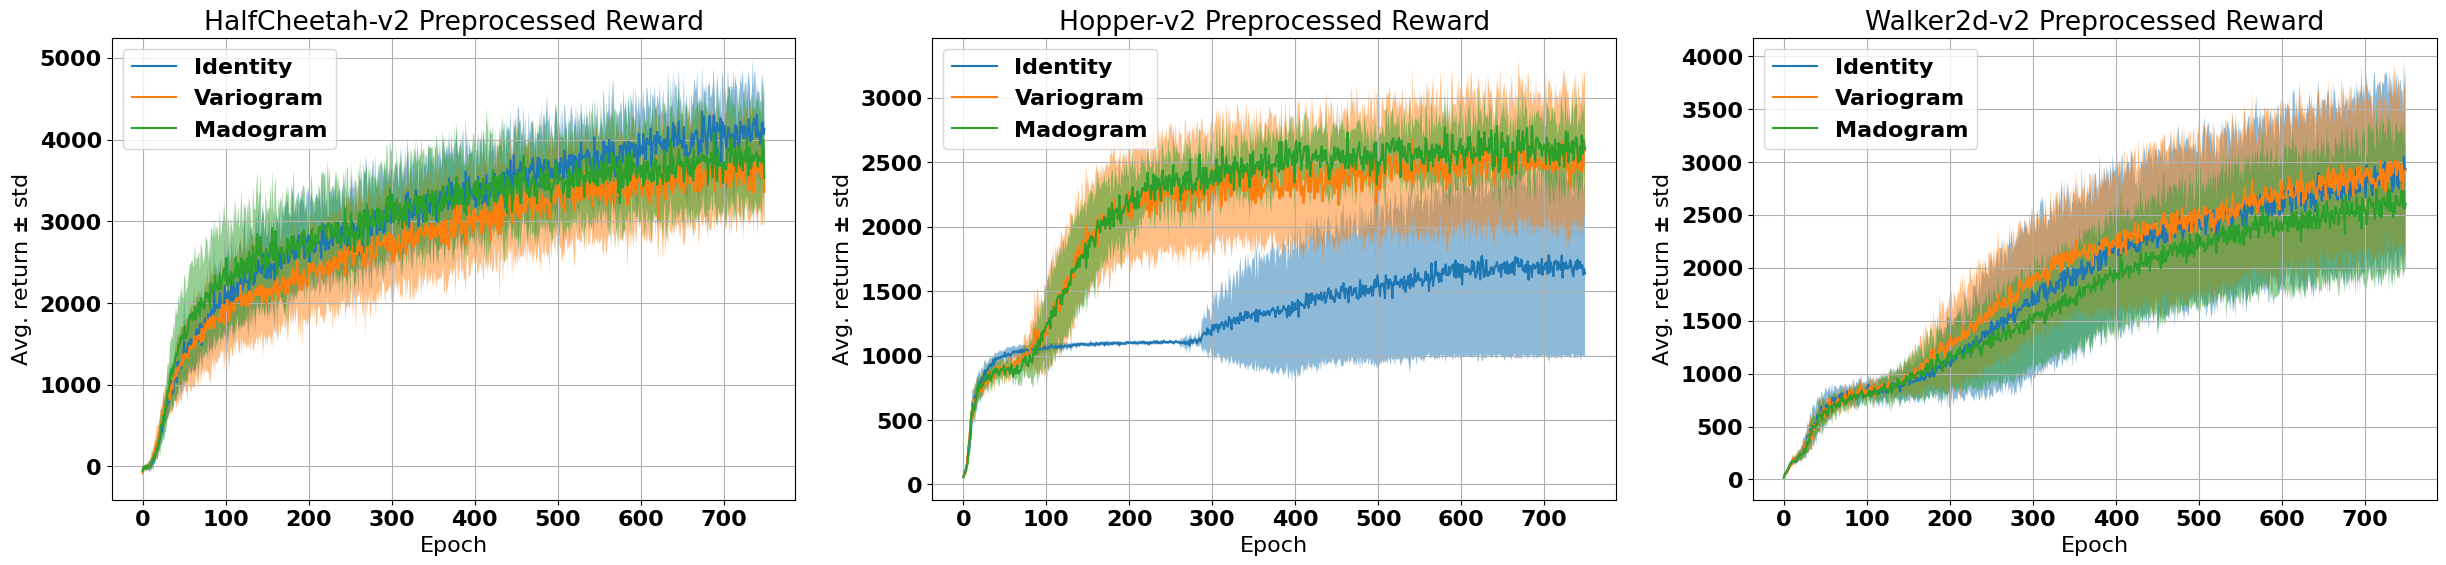

In [17]:
# Load data from the variational trials

matplotlib.style.use('default')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

save_dir = "./data17/"
env_names = ['HalfCheetah-v2', 'Hopper-v2', 'Walker2d-v2']

fig, axes = plt.subplots(1,3, figsize=(30,6))

for i, env_name in enumerate(env_names):
    data = torch.load(f"{save_dir}{env_name}.xr")
    data = data.where(data.post!='radodiv', drop=True)

    policy_dict = data.policy_dict
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    axes[i].plot(means.T)
    axes[i].legend(['Identity', 'Variogram','Madogram'], loc='upper left')
    ci = stds

    for mean, c in zip(means, ci):
        axes[i].fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
    axes[i].set_title(f"{env_name} Preprocessed Reward")
    axes[i].set_ylabel(r"Avg. return $\pm$ std")
    axes[i].set_xlabel(r"Epoch")
    axes[i].grid()
    
    
    
#     for exp_name in exp_names:  
#         plt.plot(rews.loc[exp_name].T[:,0:10])
#         plt.title(exp_name)
#         plt.figure()
#     top_seeds = {'identity':[0,1], 'cdim_div':[0,1]}

In [ ]:
# Compute different measures of dimensionality for several trajectories of each agent

for env_name in env_names:
    env = gym.make(env_name)
    data = torch.load(f"{save_dir}{env_name}.xr")
    policy_dict = data.policy_dict
    init_d = 1e-6
    num_runs = 5; num_seeds=10
    post_fns = [identity]
    ep_length= 1000


    mshdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    cdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    vdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    mdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    rdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    rews =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    for post_fn in post_fns:
        for i in range(num_seeds):
            for j in range(num_runs):
                policy = policy_dict[post_fn.__name__][i]
                o,a,r,l = do_rollout_noise(env, policy,0,0, num_steps=ep_length)
                target = o[200:]
                target = (target - policy.state_means)/(policy.state_std)
                #target = (target - target.mean(dim=0))/(target.std(dim=0))


                rews.loc[post_fn.__name__,i,j] = sum(r).item()

                mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target)
                mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
                vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
                rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)
                

    print(f"{env_name}:")           
    print("madogram dimension")
    for fn in post_fns:
        mean = mdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = mdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("variogram dimension")
    for fn in post_fns:
        mean = vdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = vdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

#     print()
#     print("rodogram dimension")
#     for fn in post_fns:
#         mean = rdims.mean(dim=('seed','run')).loc[fn.__name__].item()
#         std = rdims.std(dim=('seed','run')).loc[fn.__name__].item()
#         print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("mesh dimension")
    for fn in post_fns:
        mean = mshdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = mshdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("cmesh dimension")
    for fn in post_fns:
        mean = cdims.mean(dim=('seed', 'run')).loc[fn.__name__].item()
        std = cdims.std(dim=('seed', 'run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("rewards")
    for fn in post_fns:
        mean = rews.mean(dim=('seed', 'run')).loc[fn.__name__].item()
        std = rews.std(dim=('seed', 'run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print(); print()

# Mesh dimensions

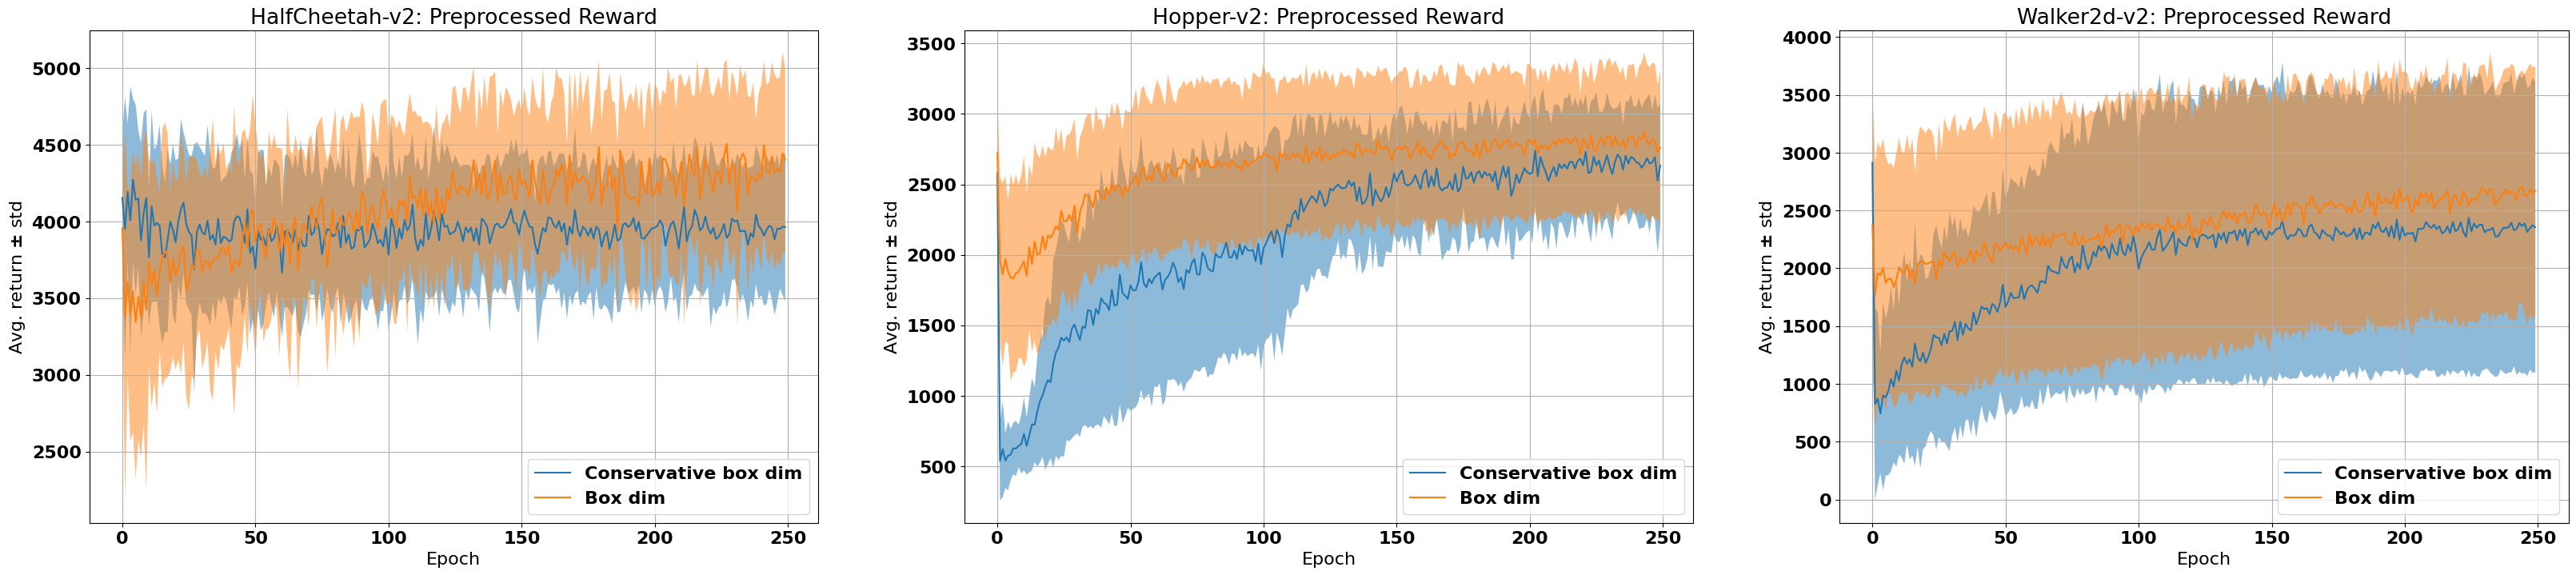

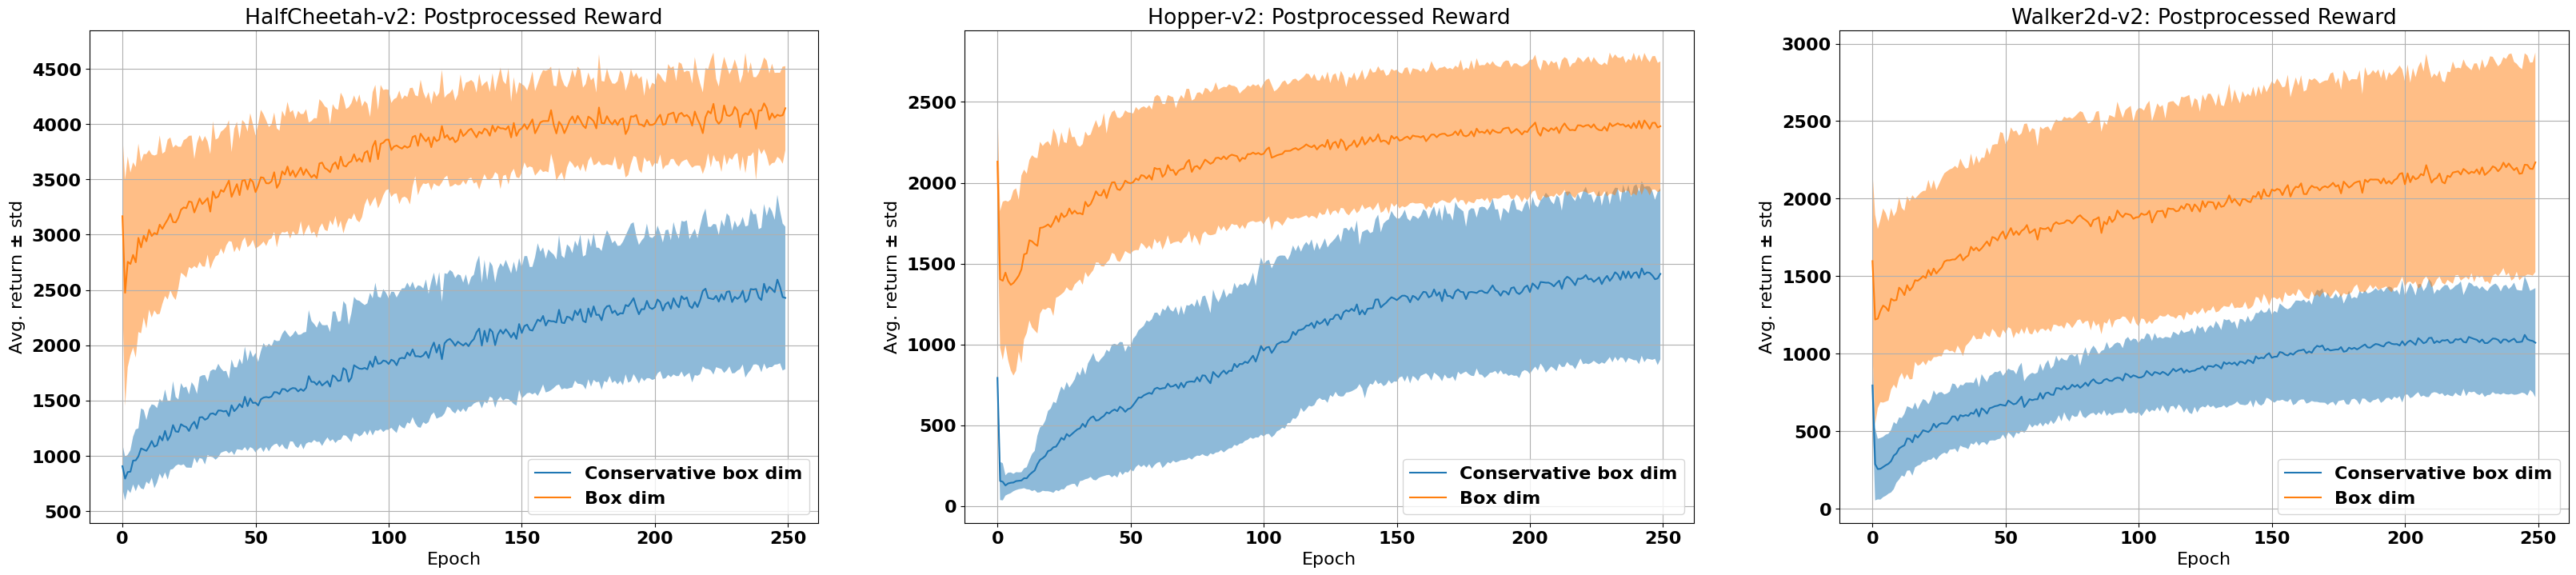

In [27]:
# Compute different measures of dimensionality for several trajectories of each agent

env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]#, "Ant-v2"]
mdim_save_dir = './data_mcshdim4/'

matplotlib.style.use('default')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
init_names = ["identity", "madodiv", "identity"]

fig, axes = plt.subplots(1,3, figsize=(40,8))

i = 0
for env_name, init_name in zip(env_names, init_names):
    init_data = torch.load(f"{save_dir}{env_name}.xr")
    init_policy_dict = init_data.policy_dict
    
    data = torch.load(f"{mdim_save_dir}{env_name}.xr")
    policy_dict = data.policy_dict
    policy_dict['identity'] = init_policy_dict['identity']
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    axes[i].plot(means.T)
    axes[i].legend(['Conservative box dim', 'Box dim'], loc='lower right')
    ci = stds

    for mean, c in zip(means, ci):
        axes[i].fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
        
    axes[i].set_title(f"{env_name}: Preprocessed Reward")
    axes[i].set_ylabel(r"Avg. return $\pm$ std")
    axes[i].set_xlabel(r"Epoch")
    axes[i].grid()
    i+=1
    
    

fig, axes = plt.subplots(1,3, figsize=(40,8))

i = 0
for env_name, init_name in zip(env_names, init_names):
    init_data = torch.load(f"{save_dir}{env_name}.xr")
    init_policy_dict = init_data.policy_dict
    
    data = torch.load(f"{mdim_save_dir}{env_name}.xr")
    policy_dict = data.policy_dict
    policy_dict['identity'] = init_policy_dict['identity']
    rews = data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    axes[i].plot(means.T)
    axes[i].legend(['Conservative box dim', 'Box dim'], loc='lower right')
    ci = stds

    for mean, c in zip(means, ci):
        axes[i].fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
        
    axes[i].set_title(f"{env_name}: Postprocessed Reward")
    axes[i].set_ylabel(r"Avg. return $\pm$ std")
    axes[i].set_xlabel(r"Epoch")
    axes[i].grid()
    i+=1


In [ ]:
# Compute different measures of dimensionality for several trajectories of each agent

env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]#, "Ant-v2"]
init_names = ["identity", "madodiv", "identity"]#, "identity"]


post_names= ['init', 'mdim_div']
post_fns = [mdim_div]


init_d = 1e-6
num_runs = 5; num_seeds=10
ep_length= 10000


post_names= ['init', 'mdim_div', 'cdim_div']
post_fns = [mdim_div, cdim_div]


for env_name, init_name in zip(env_names, init_names):
    env = gym.make(env_name)
    #init_data = torch.load(f"./data_noise1/{env_name}.xr")
    init_data = torch.load(f"{save_dir}{env_name}.xr")

    init_policy_dict = init_data.policy_dict
    
    #data = torch.load(f"./data_noise1_mdim/{env_name}.xr")
    data = torch.load(f"./{mdim_save_dir}{env_name}.xr")

    policy_dict = data.policy_dict
        
    mshdims = xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    cdims =  xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    vdims = xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    mdims = xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rdims =  xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rews =  xr.DataArray(np.zeros((len(post_fns)+1, num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    
    for post_fn in post_fns:
        for i in range(num_seeds):
            for j in range(num_runs):
                policy = policy_dict[post_fn.__name__][i]
                o,a,r,l = do_rollout_noise(env, policy, act_std=0, obs_std=0, num_steps=ep_length)
                target = o[200:]
                #target = (target - target.mean(dim=0))/target.std(dim=0)

                target = (target - policy.state_means)/(policy.state_std)
             
                rews.loc[post_fn.__name__,i,j] = sum(r).item()

                mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target, init_d=1e-6)
                mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
                vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
                rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)
                
    
    for i in range(num_seeds):
        for j in range(num_runs):
            policy = init_policy_dict[init_name][i]
            o,a,r,l = do_rollout_noise(env, policy, act_std=0, obs_std=0, num_steps=ep_length)

            #o,a,r,l = do_long_rollout(env, policy, ep_length=ep_length)
            target = o[200:]
            target = (target - policy.state_means)/(policy.state_std)
            #target = (target - target.mean(dim=0))/target.std(dim=0)


            rews.loc[post_names[0],i,j] = sum(r).item()

            mshdims.loc[post_names[0],i,j], cdims.loc[post_names[0],i,j] , _, _ = mesh_dim(target, init_d=1e-6)
            mdims.loc[post_names[0],i,j] = variation_dim(target)
            vdims.loc[post_names[0],i,j] = variation_dim(target,order=2)
            rdims.loc[post_names[0],i,j] = variation_dim(target,order=.5)
            
            
    
    print(f"{env_name}:")           
    print("madogram dimension")
    for name in post_names:
        mean = mdims.mean(dim=('seed','run')).loc[name].item()
        std = mdims.std(dim=('seed','run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("variogram dimension")
    for name in post_names:
        mean = vdims.mean(dim=('seed','run')).loc[name].item()
        std = vdims.std(dim=('seed','run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

#     print()
#     print("rodogram dimension")
#     for name in post_names:
#         mean = rdims.mean(dim=('seed','run')).loc[name].item()
#         std = rdims.std(dim=('seed','run')).loc[name].item()
#         print(f"{name} mean: {mean}, std: {std}")

    print()
    print("mesh dimension")
    for name in post_names:
        mean = mshdims.mean(dim=('seed','run')).loc[name].item()
        std = mshdims.std(dim=('seed','run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("cmesh dimension")
    for name in post_names:
        mean = cdims.mean(dim=('seed', 'run')).loc[name].item()
        std = cdims.std(dim=('seed', 'run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("rewards")
    for name in post_names:
        mean = rews.mean(dim=('seed', 'run')).loc[name].item()
        std = rews.std(dim=('seed', 'run')).loc[name].item()
        print(f"{name} mean: {mean}, std: {std}")

    print(); print()

In [ ]:
# As explained in the paper, the walker requires some extra care to only select seeds with a gait that is actually taking steps. 


env_names = ["Walker2d-v2"]
init_names = ["identity"]

init_d = 1e-6
num_runs = 5; num_seeds=10
ep_length= 1000

post_names= ['cdim_div', 'mdim_div']
post_fns = [cdim_div, mdim_div]

walking_seeds = {'cdim_div': [0,1,3,4,5,8], 'mdim_div':[0,1,3,4,5,6,8,9]}

for env_name, init_name in zip(env_names, init_names):
    env = gym.make(env_name)
    init_data = torch.load(f"./data17/{env_name}.xr")
    init_policy_dict = init_data.policy_dict
    
    data = torch.load(f"./data_mcshdim4/{env_name}.xr")
    policy_dict = data.policy_dict
    policy_dict['identity'] = init_policy_dict['identity']
        
    mshdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    cdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    vdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    mdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    rews =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": post_names})

    
    for post_fn in post_fns:
        for i in walking_seeds[post_fn.__name__]:
            for j in range(num_runs):
                policy = policy_dict[post_fn.__name__][i]
                o,a,r,l = do_rollout_noise(env, policy, act_std=0.01, obs_std=0.001, num_steps=ep_length)

                #o,a,r,l = do_long_rollout(env, policy, ep_length=ep_length)
                target = o[200:]
                target = (target - policy.state_means)/(policy.state_std)
             
                rews.loc[post_fn.__name__,i,j] = sum(r).item()

                mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target, init_d=1e-6)
                #mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
                #vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
                #rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)
                
    

    print(f"{env_name}:")           
    print("madogram dimension")
    for name in post_names:
        mean = mdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = mdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("variogram dimension")
    for name in post_names:
        mean = vdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = vdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

#     print()
#     print("rodogram dimension")
#     for name in post_names:
#         mean = rdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
#         std = rdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
#         print(f"{name} mean: {mean}, std: {std}")

    print()
    print("mesh dimension")
    for name in post_names:
        mean = mshdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = mshdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("cmesh dimension")
    for name in post_names:
        mean = cdims.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = cdims.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print()
    print("rewards")
    for name in post_names:
        mean = rews.isel(seed=walking_seeds[name]).loc[name].mean(dim=('seed','run')).item()
        std = rews.isel(seed=walking_seeds[name]).loc[name].std(dim=('seed','run')).item()
        print(f"{name} mean: {mean}, std: {std}")

    print(); print()

CPU times: user 1.11 s, sys: 0 ns, total: 1.11 s
Wall time: 1.11 s
tensor([67476.8047])
2.2234075404927873
8.3608281286677


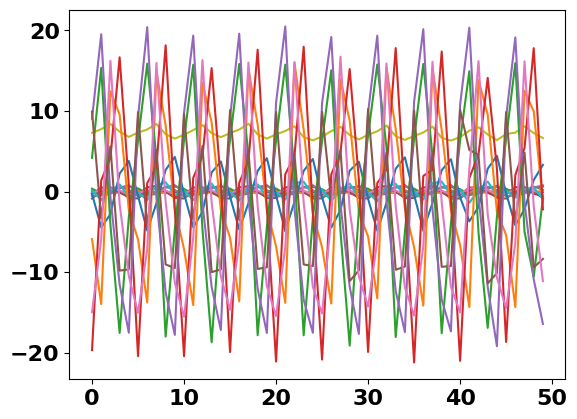

<Figure size 640x480 with 0 Axes>

In [29]:
# Some exploratory analysis of the cheetah policies

env_name = "HalfCheetah-v2"
init_data = torch.load(f"./data17/{env_name}.xr")
init_policy_dict = init_data.policy_dict

data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
seed = 2
ep_length = 10000
policy = policy_dict['identity'][seed]
env = gym.make(env_name)
%time o,a,r,_ = do_long_rollout(env, policy, ep_length= ep_length)
#o,a,r,l = do_rollout(env, policy, render=True)

plt.plot(o[1000:1050])
plt.figure()

target = o[200:]
target = (target - policy.state_means)/policy.state_std
#target = (target - policy.state_means)/policy.state_std
 
print(sum(r))
m,c,l,d = mesh_dim(target, init_d=1e-9, d_limit=1e-13)
print(m)
print(c)

CPU times: user 1.18 s, sys: 6 µs, total: 1.18 s
Wall time: 1.18 s
tensor([54242.8867])
0.38271074414894857
2.6390406839608986


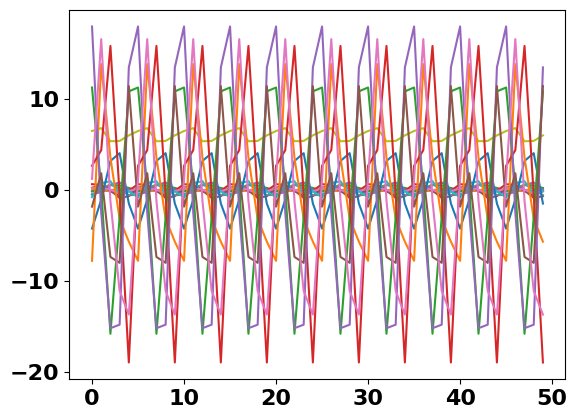

<Figure size 640x480 with 0 Axes>

In [30]:
seed = 2
ep_length = 10000
policy = policy_dict['mdim_div'][seed]
env = gym.make(env_name)
%time o2,a2,r2,_ = do_long_rollout(env, policy, ep_length= ep_length)

plt.plot(o2[1000:1050])
plt.figure()

target2 = o2[200:]
target2 = (target2 - policy.state_means)/policy.state_std
#target = (target - policy.state_means)/policy.state_std
 
print(sum(r2))
m2,c2,l2,d2 = mesh_dim(target2, init_d=1e-9, d_limit=1e-13)
print(m2)
print(c2)

CPU times: user 1.14 s, sys: 0 ns, total: 1.14 s
Wall time: 1.14 s
tensor([47451.2734])
1.6609527893815395
2.0140851522888408


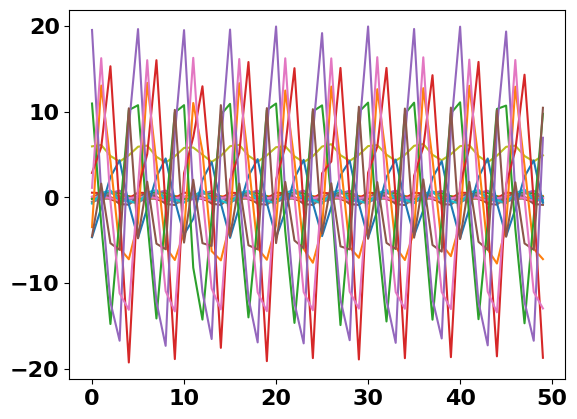

<Figure size 640x480 with 0 Axes>

In [31]:
seed = 2
ep_length = 10000
policy = policy_dict['cdim_div'][seed]
env = gym.make(env_name)
%time o3,a3,r3,_ = do_long_rollout(env, policy, ep_length= ep_length)

plt.plot(o3[1000:1050])
plt.figure()

target3 = o3[200:]
target3 = (target3 - policy.state_means)/policy.state_std
#target = (target - policy.state_means)/policy.state_std
 
print(sum(r3))
m3,c3,l3,d3 = mesh_dim(target3, init_d=1e-9, d_limit=1e-13)
print(m3)
print(c3)

<Figure size 640x480 with 0 Axes>

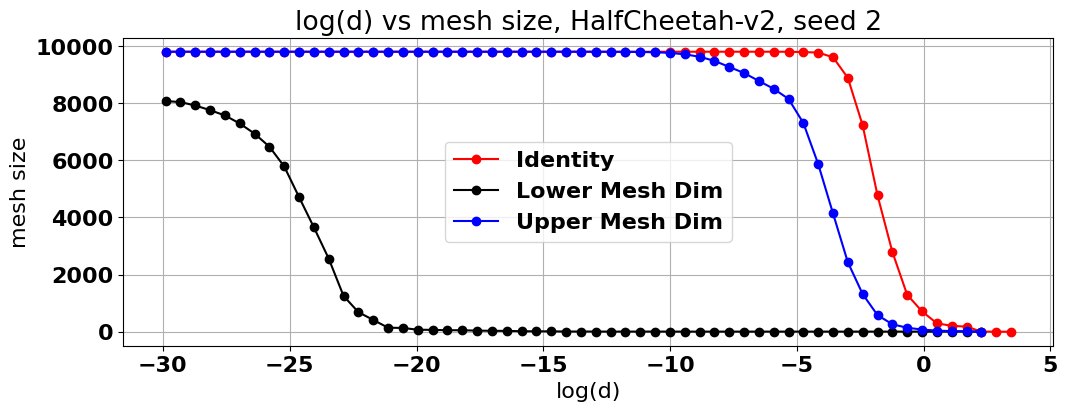

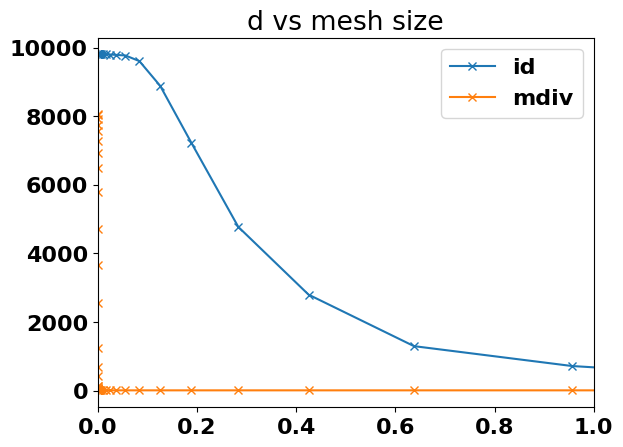

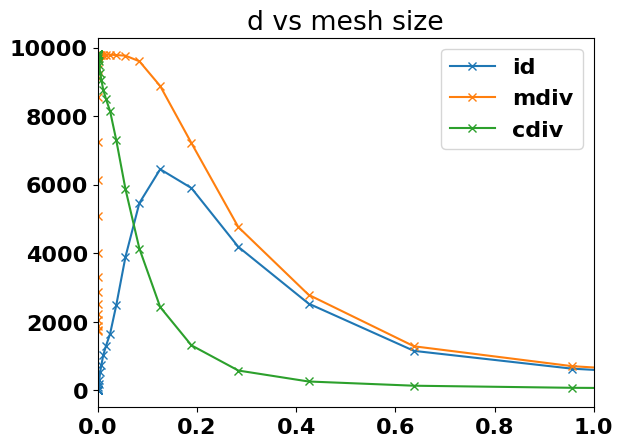

<Figure size 640x480 with 0 Axes>

In [32]:
# Examine the meshes for different box sizes for the cheetah 

# plt.plot(np.log2(d2), np.array(l[:-1]) - np.array(l2),'x-')
# plt.title('log2(d) vs cdiv mesh size')
# plt.figure()

plt.figure(figsize=(12,4))
plt.plot(np.log2(d), l,'o-', color='r')
plt.plot(np.log2(d2), l2,'o-' ,color='k')
plt.plot(np.log2(d3), l3,'o-',color='b' )

plt.legend(['Identity', 'Lower Mesh Dim','Upper Mesh Dim'])
plt.title("log(d) vs mesh size, HalfCheetah-v2, seed 2")
plt.xlabel("log(d)")
plt.ylabel("mesh size")
plt.grid()



plt.figure()

plt.plot(d, l,'x-')
plt.plot(d2, l2,'x-')
plt.legend(['id', 'mdiv'])
plt.title("d vs mesh size")
plt.xlim([0,1])
plt.figure()

plt.plot(d[:-2], np.array(l[:-2]) - np.array(l3),'x-')
plt.plot(d[:-2], np.array(l[:-2]) - np.array(l2),'x-')
plt.xlim([0,1])

plt.plot(d3, l3,'x-')
plt.legend(['id', 'mdiv', 'cdiv'])
plt.title("d vs mesh size")
plt.xlim([0,1])
plt.figure()

In [33]:
# Analyis for the different agents subjects to push disturbances

# Must comment out whichever agent you want to analyze
#===============================
env_name = "Walker2d-v2"
post_names = ['identity', 'mdim_div']
seeds = [0,1,3,4,5,6]
#===============================
# env_name = "HalfCheetah-v2"
# post_names = ['identity', 'mdim_div']
# seeds = [0,1,2,3,4,5,6,7,8,9]
#===============================
# env_name = "Hopper-v2"
# post_names = ['madodiv', 'mdim_div']
# seeds = [0,1,2,3,4,5,6,7,8,9]
# ===============================
num_runs = 10
num_preruns = 5

env = gym.make(env_name)
data = torch.load(f"./data17/{env_name}.xr")
init_policy_dict = data.policy_dict

data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']

fails = xr.DataArray(np.zeros((2, len(seeds), num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": post_names})

num_steps = 10000

for i_post, post in enumerate(post_names):
    for i_seed, seed in enumerate(seeds):
        pre_x_list = []
        for pre_run in range(num_preruns):
            obs, acts, rews, x_list = do_rollout_push(env, policy_dict[post][seed], magnitude=0, rate=0, num_steps=num_steps, render=False)
            pre_x_list.append(x_list[-1])

        x_target = .85*torch.tensor(pre_x_list).mean()

        for run in range(num_runs):
            obs, acts, rews, x_list = do_rollout_push(env, policy_dict[post][seed], magnitude=5, rate=.2, num_steps=num_steps, render=False)
            if(x_list[-1] < x_target):
                fails[i_post, i_seed, run] = 1
print(f"fail_mean: {fails.mean(dim=('run','seed')).to_dataframe('')}")

fail_mean:                   
post              
identity  0.116667
mdim_div  0.016667


In [34]:
fails.mean(dim=('run')).to_dataframe('')

post     seed     
identity 0     0.3
         1     0.0
         2     0.0
         3     0.0
         4     0.4
         5     0.0
mdim_div 0     0.0
         1     0.0
         2     0.0
         3     0.0
         4     0.0
         5     0.1

In [38]:
# Analyis for the different agents subjects to noise

# Must comment out whichever agent you want to analyze
#===============================
# env_name = "Walker2d-v2"
# post_names = ['identity', 'mdim_div']
# seeds = [0,1,3,4,5,6]
#===============================
# env_name = "HalfCheetah-v2"
# post_names = ['identity', 'mdim_div']
# seeds = [0,1,2,3,4,5,6,7,8,9]
#===============================
env_name = "Hopper-v2"
post_names = ['madodiv', 'mdim_div']
seeds = [0,1,2,3,4,5,6,7,8,9]
# ===============================
num_runs = 10
num_preruns = 5


env = gym.make(env_name)
data = torch.load(f"./data17/{env_name}.xr")
init_policy_dict = data.policy_dict

data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']


fails = xr.DataArray(np.zeros((2, len(seeds), num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": post_names})

num_steps = 10000
act_std = 0
obs_std = .010
   
for i_post, post in enumerate(post_names):
    for i_seed, seed in enumerate(seeds):
        pre_x_list = []
        for pre_run in range(num_preruns):
            obs, acts, rews, x_list = do_rollout_noise(env, policy_dict[post][seed], obs_std=0, act_std=0, num_steps=num_steps, render=False)
            pre_x_list.append(x_list[-1])

        x_target = .85*torch.tensor(pre_x_list).mean()

        for run in range(num_runs):
            obs, acts, rews, x_list = do_rollout_noise(env, policy_dict[post][seed], obs_std=obs_std, act_std=act_std, num_steps=num_steps, render=False)
            if(x_list[-1] < x_target):
                fails[i_post, i_seed, run] = 1

print(f"fail_mean: {fails.mean(dim=('run','seed')).to_dataframe('')}, noise_std: {act_std}")

fail_mean:               
post          
madodiv   0.21
mdim_div  0.25, noise_std: 0


In [ ]:
fails.mean(dim=('run')).to_dataframe('')